# Using SDF in Asset Pricing

## 1. import relative package

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import time

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import concatenate
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K
from keras.optimizers import Adam
from keras.models import model_from_json

Using TensorFlow backend.


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

## 2. import micro, macro and return data from local
data comes from Wind.api

In [5]:
file = open('a','rb')
dataset = pickle.load(file, encoding='utf-8')
file.close()

In [6]:
macro_data, micro_data, return_data = dataset
print(macro_data.shape, micro_data.shape, return_data.shape)
print(list(map(type, dataset)))

(3233, 13, 15) (3233, 50, 10) (3233, 50)
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


In [7]:
# dataset split
train_micro = micro_data[:2000, :, :]
train_macro = macro_data[:2000, :, :]
train_return = return_data[1:2001, :]

validation_micro = micro_data[2001:2600, :, :]
validation_macro = macro_data[2001:2600, :, :]
validation_return = return_data[2002:2601, :]

test_micro = micro_data[2601:-1, :, :]
test_macro = macro_data[2601:-1, :, :]
test_return = return_data[2602:, :]

## 3. Training Process

#### 3.1 model parameters

In [8]:
# model parameter
ndays = train_micro.shape[0]
nstocks = train_micro.shape[1]
nmacro = train_macro.shape[2]
nmicro = train_micro.shape[2]
LSTM_delay = train_macro.shape[1]
n_g = 8

#### 3.2 SGD Network

Including one LSTM to deal with Macro-variables with 4 hidden states，then the both the hidden states and the micro-variables go in to a 64-64-1 DNN. After that we are able to construct $M_{t+1}R_{t+1}$，and with the given $g$ function，we can calculate and minimize the MSE.

In [9]:
# SGD networks

# data loading
macro_in1 = Input(shape=(LSTM_delay, nmacro))

micro_in1 = Input(shape=(nstocks,nmicro))

return_next_date1 = Input(shape=(nstocks,))


# LSTM
sgd_lstm_out = LSTM(6)(macro_in1) # (1000, 4)
sgd_lstm_out = Lambda(lambda x:K.repeat(x, nstocks))(sgd_lstm_out)


# SGD weights DNN
sgd_weights_input = concatenate([micro_in1, sgd_lstm_out]) # (1000, 50, 104)  

sgd_weights_output = Dense(128, activation='relu')(sgd_weights_input)
sgd_weights_output = Dense(128, activation='relu')(sgd_weights_input)
sgd_weights_output = Dense(128, activation='relu')(sgd_weights_input)
sgd_weights_output = Dense(1)(sgd_weights_input)
sgd_weights_output = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks)))(sgd_weights_output)


# SGD construction
def construction(x):
    tmp = 1 - x[0] * x[1]
    tmp = K.sum(tmp, axis=1)
    tmp = K.reshape(tmp, shape=(-1,1)) # (1000, 1)
    tmp = K.repeat(tmp, nstocks) # (1000, 50, 1)
    tmp = K.reshape(tmp, shape=(-1,nstocks)) # (1000, 50)
    tmp = tmp * x[1] # (1000, 50)
    tmp = K.reshape(tmp, shape=(-1, nstocks, 1))
    return tmp # the M_{t+1}R_{t+1}

sgd_construction_ouput = Lambda(construction)([sgd_weights_output,return_next_date1])


# attain con_g_output from conditional network
con_g_output_loaded = Input(shape=(nstocks, n_g))


# combine those two and calculate loss
loss_function_w = Lambda(lambda x:x[0]*x[1])([sgd_construction_ouput, con_g_output_loaded]) # (1000,50, 8)
loss_function_w = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks*n_g)))(loss_function_w)


# with weights output for validation and sgd output for condition network training
model_output_w = Model(inputs=[macro_in1, micro_in1], outputs=sgd_weights_output) # acquires weights given info
model_output_sgd = Model(inputs=[macro_in1, micro_in1, return_next_date1], outputs=sgd_construction_ouput) # acquires MR for condition networks


# SGD model compile
model_w = Model(inputs=[macro_in1, micro_in1, return_next_date1, con_g_output_loaded], outputs=loss_function_w)
model_w.compile(optimizer='adam', loss='mean_squared_error')


In [22]:
model_output_sgd.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13, 15)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6)            528         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50, 10)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 6)        0           lstm_1[0][0]                     
____________________________________________________________________________________________

#### 3.3 Conditional Neural Nets

Including one LSTM for dealing with Macro-variables with 4 hidden states, then the hidden states and micro-variables goin to a 64-8 DNN，and finally with given $g$，we can calculate $M_{t+1}R_{t+1}$，and maximize the MSE.

In [12]:
# conditional networks

macro_in2 = Input(shape=(LSTM_delay, nmacro))

micro_in2 = Input(shape=(nstocks,nmicro))

sgd_construction_ouput_loaded = Input(shape=(nstocks,1))

con_lstm_out = LSTM(6)(macro_in2) # (1000, 4)
con_lstm_out = Lambda(lambda x:K.repeat(x, nstocks))(con_lstm_out)

con_weights_input = concatenate([micro_in2, con_lstm_out]) # (1000, 50, 104)  

# con_g_output = Dense(64, activation='relu')(con_weights_input)
# con_g_output = Dense(n_g)(con_g_output) # (1000, 50, 8)
con_g_output = Dense(n_g)(con_weights_input) # (1000, 50, 8)

loss_function_g = Lambda(lambda x:K.log(1/(1+K.abs(x[0]*x[1]))))([sgd_construction_ouput_loaded, con_g_output]) # (1000,50, 8)
loss_function_g = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks*n_g)))(loss_function_g)

model_output_g = Model(inputs=[macro_in2, micro_in2], outputs=con_g_output) # acquires MR for condition networks

model_g = Model(inputs=[macro_in2, micro_in2, sgd_construction_ouput_loaded], outputs=loss_function_g)
model_g.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model_g.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 13, 15)       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6)            528         input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50, 10)       0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 50, 6)        0           lstm_2[0][0]                     
____________________________________________________________________________________________

#### 3.4 data training process

In [16]:
# data process
y_train = np.zeros((ndays, n_g*nstocks))
macro_in = train_macro
micro_in = train_micro
return_next_date = train_return
function_g = np.ones((ndays, nstocks, n_g))
sdf_loss = []

epoch = 10
batch_size = 200
n_iteration = 10

for i in range(n_iteration):
    t1 = time.time()

    # SDF nets
    history_w = model_w.fit([macro_in, micro_in, return_next_date, function_g], y_train, epochs=epoch, batch_size=batch_size, verbose=0)
    function_sgd = model_output_sgd.predict([macro_in, micro_in, return_next_date])
    sdf_loss = sdf_loss + history_w.history['loss'].copy() # save loss

    # conditional nets
    model_g.fit([macro_in, micro_in, function_sgd], y_train, epochs=epoch, batch_size=batch_size, verbose=0)
    function_g = model_output_g.predict([macro_in, micro_in])
    print('done with', i,',sdf loss is', sdf_loss[-1], ', using', round(time.time()-t1, 2), 'seconds')

done with 0 ,sdf loss is 13.833345031738281 , using 1.82 seconds
done with 1 ,sdf loss is 44.85225945711136 , using 1.76 seconds
done with 2 ,sdf loss is 4.544832932949066 , using 1.62 seconds
done with 3 ,sdf loss is 0.23430258855223657 , using 1.57 seconds
done with 4 ,sdf loss is 0.16910651214420797 , using 1.59 seconds
done with 5 ,sdf loss is 0.0836984152905643 , using 1.76 seconds
done with 6 ,sdf loss is 0.15144584039226175 , using 1.76 seconds
done with 7 ,sdf loss is 0.228369352966547 , using 1.53 seconds
done with 8 ,sdf loss is 0.21663680095225574 , using 1.53 seconds
done with 9 ,sdf loss is 0.19589672377333045 , using 1.66 seconds


In [23]:
history_w.history

{'loss': [0.20613515200093388,
  0.20515614124014975,
  0.20397405019029974,
  0.20305944150313734,
  0.2018925274722278,
  0.20055954977869989,
  0.19937635399401188,
  0.19810822932049632,
  0.19684115583077072,
  0.19589672377333045]}

In [11]:
# save weights model

# model_json = model_output_w.to_json()
# with open("model_w.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")

In [12]:
# read data

# with open("model_w.json", "r") as json_file:
#     mode_s = model_from_json(json_file.read())
# mode_s.load_weights("model.h5")

## Result Analysis

#### the trend of loss function

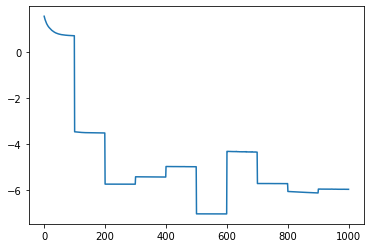

In [13]:
plt.plot(np.log(sdf_loss))

In [26]:
train_weights = model_output_w.predict([train_macro[:,:], train_micro[:, :, :]])
train_weights = (train_weights - train_weights.mean(axis=1).reshape(-1,1)) / train_weights.std(axis=1).reshape(-1,1)
train_weights = 1/(1+np.exp(-train_weights))

In [28]:
train_weights.shape

(2000, 50)

#### Training Set

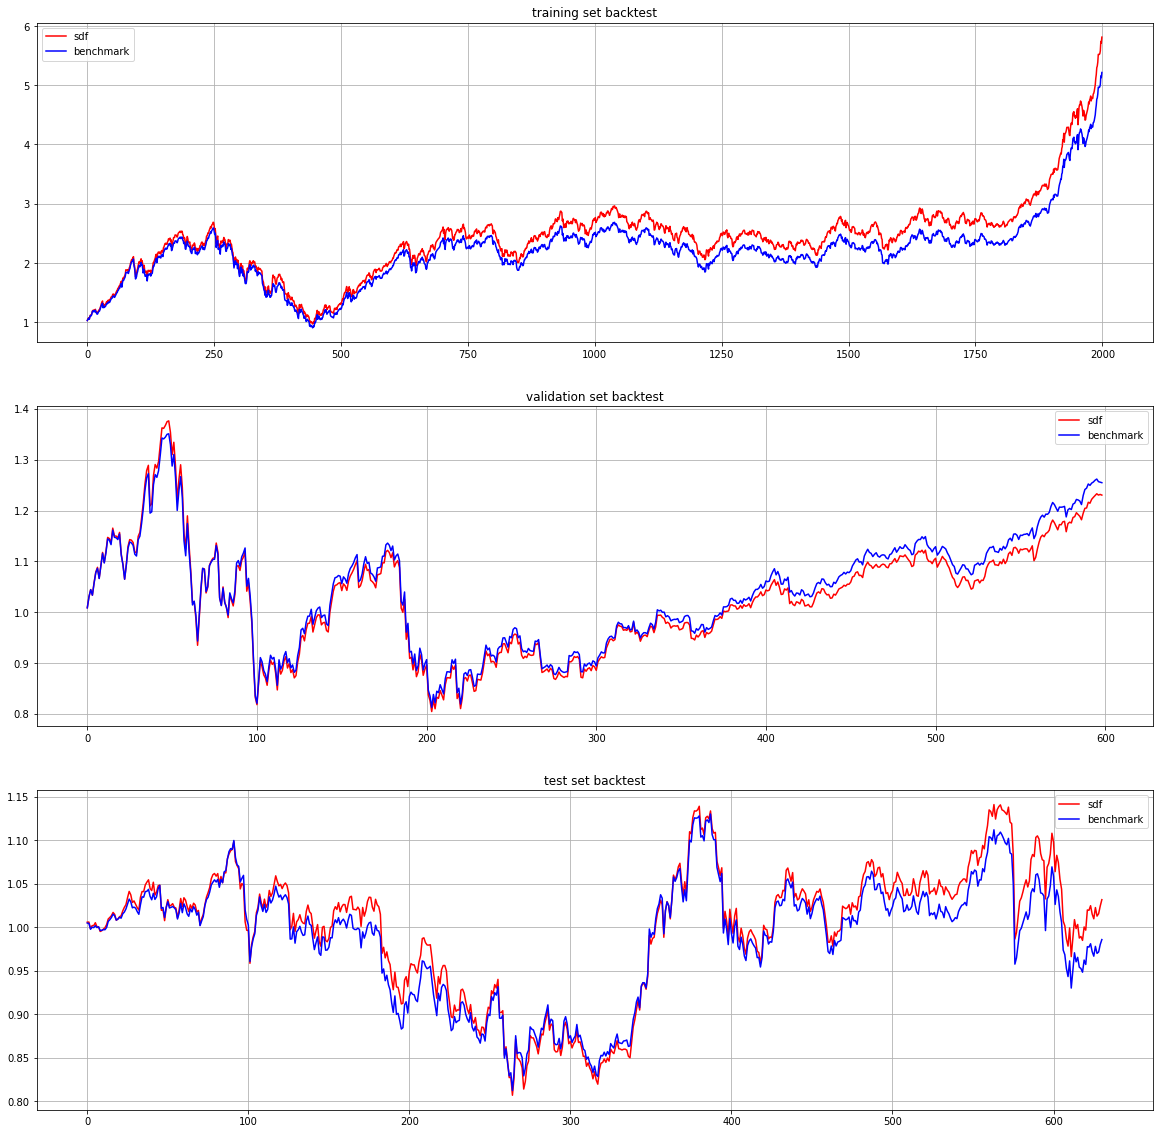

,mean,std,shape,SR,bench_mean,bench_std,bench_SR
train,0.259854,0.275248,2000,0.944072,0.245355,0.272073,0.901796
validation,0.130169,0.291323,599,0.446821,0.136844,0.285843,0.478737
test,0.035148,0.212196,631,0.165640,0.015675,0.206131,0.076042


In [14]:
result = pd.DataFrame([[0,0,0,0, 0, 0, 0] for i in range(3)], columns = ['mean','std','shape','SR','bench_mean','bench_std','bench_SR'], index=['train','validation','test'])

# training set condition
train_weights = model_output_w.predict([train_macro[:,:], train_micro[:, :, :]])
train_weights = (train_weights - train_weights.mean(axis=1).reshape(-1,1)) / train_weights.std(axis=1).reshape(-1,1)
train_weights = 1/(1+np.exp(-train_weights))
# train_yield = train_weights
train_daily_return = (train_weights/train_weights.sum(axis=1).reshape(-1,1) * train_return).sum(axis=1)
result.iloc[0, 0] = train_daily_return.mean()*252
result.iloc[0, 1] = train_daily_return.std() * np.sqrt(252)
result.iloc[0, 2] = train_daily_return.shape

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
benchmark = train_return.mean(axis=1)
ax1.plot(np.cumprod(1+train_daily_return), color='red',label='sdf')
ax1.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.title('training set backtest')
plt.grid()

result.iloc[0, 3] = train_daily_return.mean()/train_daily_return.std()*np.sqrt(252)
result.iloc[0, 4] = benchmark.mean()*252
result.iloc[0, 5] = benchmark.std()*np.sqrt(252)
result.iloc[0, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)


# training set condition
validation_weights = model_output_w.predict([validation_macro[:,:], validation_micro[:, :, :]])
validation_weights = (validation_weights - validation_weights.mean(axis=1).reshape(-1,1)) / validation_weights.std(axis=1).reshape(-1,1)
validation_weights = 1/(1+np.exp(-validation_weights))
# train_yield = train_weights
validation_daily_return = (validation_weights/validation_weights.sum(axis=1).reshape(-1,1) * validation_return).sum(axis=1)
result.iloc[1, 0] = validation_daily_return.mean()*252
result.iloc[1, 1] = validation_daily_return.std() * np.sqrt(252)
result.iloc[1, 2] = validation_daily_return.shape

benchmark = validation_return.mean(axis=1)
ax2 = fig.add_subplot(312)
ax2.plot(np.cumprod(1+validation_daily_return), color='red',label='sdf')
ax2.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.grid()
plt.title('validation set backtest')

result.iloc[1, 3] = validation_daily_return.mean()/validation_daily_return.std()*np.sqrt(252)
result.iloc[1, 4] = benchmark.mean()*252
result.iloc[1, 5] = benchmark.std()*np.sqrt(252)
result.iloc[1, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)

# training set condition
test_weights = model_output_w.predict([test_macro[:,:], test_micro[:, :, :]])
test_weights = (test_weights - test_weights.mean(axis=1).reshape(-1,1)) / test_weights.std(axis=1).reshape(-1,1)
test_weights = 1/(1+np.exp(-test_weights))
# train_yield = train_weights
test_daily_return = (test_weights/test_weights.sum(axis=1).reshape(-1,1) * test_return).sum(axis=1)
result.iloc[2, 0] = test_daily_return.mean()*252
result.iloc[2, 1] = test_daily_return.std() * np.sqrt(252)
result.iloc[2, 2] = test_daily_return.shape

benchmark = test_return.mean(axis=1)
ax2 = fig.add_subplot(313)
plt.plot(np.cumprod(1+test_daily_return), color='red',label='sdf')
plt.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.grid()
plt.title('test set backtest')

result.iloc[2, 3] = test_daily_return.mean()/test_daily_return.std()*np.sqrt(252)
result.iloc[2, 4] = benchmark.mean()*252
result.iloc[2, 5] = benchmark.std()*np.sqrt(252)
result.iloc[2, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)

plt.show()
result

In [31]:
(85*0.935-2.5*0.9525)/0.97

79.47809278350518